In [1]:
# PROCESS THE GAIA DR3 RADIAL VELOCITY CATALOG:
# https://gea.esac.esa.int/archive/
#
#
# ZACK REEVES
# CREATED: 2024
#
# VERSIONS:
#  1.1  MAR 2024 CREATE JUPYTER NOTEBOOK

In [ ]:
#This code pulls a catalogue from Gaia DR3 of each star that has a reliable radial velocity
#Based on https://www.aanda.org/articles/aa/full_html/2023/06/aa44220-22/aa44220-22.html#S14,
#We correct radial velocities for stars of high magnitude grvs_mag>11 by Katz et al.
#We also correct stars of high effective temperature 14500>rv_template_teff>8500 and 6>grvs_mag>12 by Blomme et al. as recommended by Katz^

In [2]:
# Define the metadata for the data set. 
metadata = {}

metadata['project'] = 'Digital Universe Atlas Gaia Subsets'
metadata['sub_project'] = 'Gaia DR3 Radial Velocities'

metadata['catalog'] = 'Gaia Data Release 3: Properties and validation of the radial velocities (Katz et al., 2023)'
metadata['author'] = 'Katz et al.'
metadata['prepared_by'] = 'Zack Reeves (AMNH)'
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'Gaia DR3 Radial Velocity'
metadata['data_group_desc'] = 'Gaia DR3 Radial Velocity'
metadata['fileroot'] = 'gdr3rv'

In [5]:
import pandas as pd
import numpy as np
import sys
import os
import collections

import astropy.units as u
import astropy.coordinates
from astropy.table import Table
from astropy.io import ascii

from astroquery.gaia import Gaia

sys.path.insert(0, '..')
from common import file_functions, calculations

from matplotlib import pyplot as plt, colors

In [4]:
#query the catalogue from Gaia
#https://gea.esac.esa.int/archive/
#The query pulls the source id, positional data, velocity data as well as teff and magnitude for correction purposes
#corrective data included in the query was informed by https://www.aanda.org/articles/aa/full_html/2023/06/aa44220-22/aa44220-22.html#S14

In [ ]:
#log in to Gaia Server - Can change to different credentials file for a different user
#query runs in a little over an hour
#file is 2.9 gigabytes, 33,653,049 objects
Gaia.login(credentials_file='../common/gaia_credentials.txt')

#Query Gaia DR3 source for parallaxes
job = Gaia.launch_job_async("select a.source_id, a.ra, a.dec, a.pmra, a.pmdec, a.parallax, a.parallax_error, a.radial_velocity, a.radial_velocity_error, a.grvs_mag, a.rv_template_teff, "
                            "bj.r_med_geo, bj.r_hi_geo, bj.r_lo_geo, bj.r_med_photogeo, bj.r_hi_photogeo, bj.r_lo_photogeo "
                            "from gaiadr3.gaia_source a left join external.gaiaedr3_distance bj on a.source_id = bj.source_id "
                            "where a.radial_velocity is not null",
                            dump_to_file=False)

#Put the resulting table into a Table
data = job.get_results()
    
#Deleting table and job from Gaia ESA server so we don't clog the memory
Gaia.delete_user_table('gaia_ids')
Gaia.remove_jobs(job.jobid)

Gaia.logout()

In [7]:
data = Table.read('raw_data/1709681335394O-result.fits')

In [8]:
data

source_id,ra,dec,pmra,pmdec,parallax,parallax_error,radial_velocity,radial_velocity_error,grvs_mag,rv_template_teff,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo
,deg,deg,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,K,pc,pc,pc,pc,pc,pc
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
4052307003895216512,275.4300051341523,-27.162097996514365,-3.4195359612431258,-6.489931203150567,0.12430433641824773,0.041029386,-906.6071,7.732392,--,4250.0,6048.466,7343.283,5084.1294,6308.3813,7548.4297,5149.2627
3001468183198140800,94.63031223261366,-10.632227248225552,-1.6486698736842267,-0.1971523664224419,4.520102588209706,0.030701878,-885.2032,7.120261,13.5555105,3600.0,218.84166,220.28473,217.67738,219.26723,220.85509,217.947
4313545645245332864,286.13948006161826,12.0431615518879,-0.6784563757373283,0.7648214399559667,0.783335824290454,0.027398903,-878.91626,7.8022933,--,5500.0,1224.2854,1267.9232,1188.1262,1215.8363,1266.3618,1180.253
4255077877498765696,281.90365531215446,-5.0767822559196665,-2.216158120835281,-2.891394135929329,0.994219806143925,0.037234988,-877.84454,12.099504,13.724741,4750.0,966.3308,1001.6573,928.8468,984.2755,1017.2316,952.0411
670746696180987648,121.6770300797143,21.12650542008284,0.600820562000813,2.914811263251899,1.0020618410086095,0.027322844,-871.40405,13.431914,13.825596,5750.0,957.37524,978.358,933.14874,956.0024,979.6562,934.2533
5874745572821181824,223.50837197461692,-61.95391247292645,-3.4542618577212876,-2.79906275134224,-0.34697853800944983,0.13460016,-870.24866,9.397288,13.356203,5500.0,10288.409,15235.067,7127.0156,7715.392,8213.422,6236.6094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6723146611802180224,276.61627312431835,-41.44861866093739,0.8386388589101175,-22.519912111271495,0.9789844285624029,0.023672763,859.6903,7.3817263,13.783728,5500.0,972.6756,998.6112,952.2095,981.62976,1002.1452,952.81116


In [9]:
#determining correct Bailer-Jones distance
data['bj_distance'] = [data['r_med_photogeo'][i] if((not(np.ma.is_masked(data['r_med_photogeo'][i])))&(data['r_med_geo'][i]>500)) else data['r_med_geo'][i] for i in range(len(data))]
data['bj_distance'].unit = u.pc

data['e_bj_dist'] = [(data['r_hi_photogeo'][i]-data['r_lo_photogeo'][i])/2 if((not(np.ma.is_masked(data['r_med_photogeo'][i])))&(data['r_med_geo'][i]>500)) else (data['r_hi_geo'][i]-data['r_lo_geo'][i])/2 for i in range(len(data))]
data['e_bj_dist'].unit = u.pc

In [ ]:
#applying corrections from papers
data['radial_velocity_correction'] = [0.0]*len(data)

#Katz correction
katz_indexes = np.where(data['grvs_mag']>11)[0]
data['radial_velocity_correction'][katz_indexes] = [(0.02755*data['grvs_mag'][i]**2 - 0.55863*data['grvs_mag'][i] + 2.81129) for i in range(len(katz_indexes))]

#Blomme correction
blomme_indexes = np.where((data['grvs_mag']>11)&(data['rv_template_teff']>8500)&(data['rv_template_teff']>14500))[0]
data['radial_velocity_correction'][blomme_indexes] = [7.98 - 1.135*data['grvs_mag'][i] for i in range(len(blomme_indexes))]

data['corrected_radial_velocity'] = np.subtract(data['radial_velocity'], data['radial_velocity_correction'])
data['corrected_radial_velocity'].unit=u.km/u.s

In [24]:
#calculating distance in light years and parsecs
calculations.get_distance(data, dist='bj_distance', use='distance')

In [31]:
#calculating cartesian coordinates
calculations.get_cartesian(data, ra='ra', dec='dec', pmra='pmra', pmde='pmdec', radial_velocity='corrected_radial_velocity', frame='icrs')

<function matplotlib.pyplot.show(close=None, block=None)>

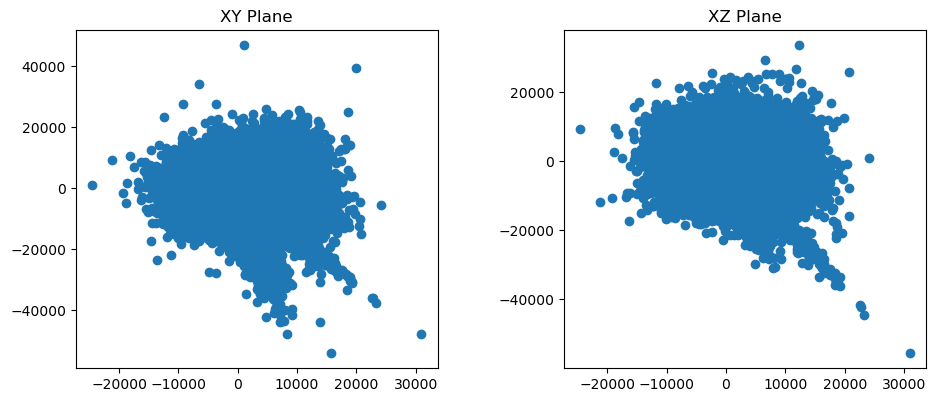

In [26]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

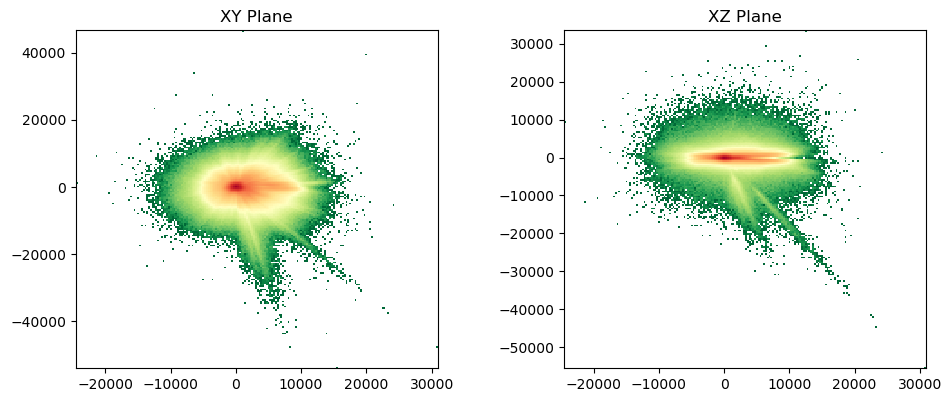

In [45]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(data['x'], data['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(data['x'], data['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [37]:
len(np.where(data['e_bj_dist']/data['bj_distance']>0.20)[0])

1204529

In [ ]:
edata = data[np.where(data['e_bj_dist']/data['bj_distance']<0.10)[0]]

In [ ]:
#2D Density Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].hist2d(edata['x'], edata['y'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].hist2d(edata['x'], edata['z'], 
           bins = 200,  
           norm = colors.LogNorm(),  
           cmap = "RdYlGn_r",) 
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
#plt.show

In [32]:
#threshing
data

source_id,ra,dec,pmra,pmdec,parallax,parallax_error,radial_velocity,radial_velocity_error,grvs_mag,rv_template_teff,r_med_geo,r_hi_geo,r_lo_geo,r_med_photogeo,r_hi_photogeo,r_lo_photogeo,bj_distance,e_bj_dist,radial_velocity_correction,corrected_radial_velocity,dist_pc,dist_ly,x,y,z,speck_label,label,u,v,w,speed
,deg,deg,mas / yr,mas / yr,mas,mas,km / s,km / s,mag,K,pc,pc,pc,pc,pc,pc,pc,pc,,km / s,pc,lyr,pc,pc,pc,,,km / s,km / s,km / s,
int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float32,float32,float64,float64,float64,str22,str27,float64,float64,float64,float64
4052307003895216512,275.4300051341523,-27.162097996514365,-3.4195359612431258,-6.489931203150567,0.12430433641824773,0.041029386,-906.6071,7.732392,--,4250.0,6048.466,7343.283,5084.1294,6308.3813,7548.4297,5149.2627,6308.3813,1199.58349609375,0.0,-906.6071166992188,6308.381348,20575.2,6244.546799,596.733389,-667.247905,#__4052307003895216512,GaiaDR3_4052307003895216512,-876.426272,-304.119043,97.206103,932.770298
3001468183198140800,94.63031223261366,-10.632227248225552,-1.6486698736842267,-0.1971523664224419,4.520102588209706,0.030701878,-885.2032,7.120261,13.5555105,3600.0,218.84166,220.28473,217.67738,219.26723,220.85509,217.947,218.84166,1.3036727905273438,nan,nan,218.841660,713.8,-166.760957,-134.103992,-45.810203,#__3001468183198140800,GaiaDR3_3001468183198140800,nan,nan,nan,nan
4313545645245332864,286.13948006161826,12.0431615518879,-0.6784563757373283,0.7648214399559667,0.783335824290454,0.027398903,-878.91626,7.8022933,--,5500.0,1224.2854,1267.9232,1188.1262,1215.8363,1266.3618,1180.253,1215.8363,43.05438232421875,0.0,-878.916259765625,1215.836304,3965.5,856.771944,860.907016,55.125886,#__4313545645245332864,GaiaDR3_4313545645245332864,-621.040106,-621.012799,-34.362840,878.936013
4255077877498765696,281.90365531215446,-5.0767822559196665,-2.216158120835281,-2.891394135929329,0.994219806143925,0.037234988,-877.84454,12.099504,13.724741,4750.0,966.3308,1001.6573,928.8468,984.2755,1017.2316,952.0411,984.2755,32.59527587890625,0.301139051751687,-878.1456825087829,984.275513,3210.3,868.959746,461.599615,-25.160285,#__4255077877498765696,GaiaDR3_4255077877498765696,-767.350667,-426.557486,25.503667,878.310180
670746696180987648,121.6770300797143,21.12650542008284,0.600820562000813,2.914811263251899,1.0020618410086095,0.027322844,-871.40405,13.431914,13.825596,5750.0,957.37524,978.358,933.14874,956.0024,979.6562,934.2533,956.0024,22.701446533203125,nan,nan,956.002380,3118.1,-803.865430,-311.574597,413.112808,#__670746696180987648,GaiaDR3_670746696180987648,nan,nan,nan,nan
5874745572821181824,223.50837197461692,-61.95391247292645,-3.4542618577212876,-2.79906275134224,-0.34697853800944983,0.13460016,-870.24866,9.397288,13.356203,5500.0,10288.409,15235.067,7127.0156,7715.392,8213.422,6236.6094,7715.392,988.40625,0.3337905341197236,-870.5824477606823,7715.392090,25164.2,5620.387142,-5275.540014,-327.415689,#__5874745572821181824,GaiaDR3_5874745572821181824,-744.086306,480.293070,3.135214,885.638579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6723146611802180224,276.61627312431835,-41.44861866093739,0.8386388589101175,-22.519912111271495,0.9789844285624029,0.023672763,859.6903,7.3817263,13.783728,5500.0,972.6756,998.6112,952.2095,981.62976,1002.1452,952.81116,981.62976,24.667022705078125,0.31442380881589704,859.3758838083716,981.629761,3201.6,948.115748,-118.374252,-225.080100,#__6723146611802180224,GaiaDR3_6723146611802180224,807.688118,-195.191094,-243.031344,865.750480


In [28]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+str(name) for name in data['source_id']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                  description='Gaia DR3 Source ID')

#construct a label column
data['label'] = ['GaiaDR3_'+ str(source) for source in data['source_id']]  #leaving for now in case we want to add other labels

In [33]:
#construct a metadata table
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'dist_ly', 'u', 'v', 'w', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,Position (x coordinate) in pc
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in pc
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in pc
3,dist_ly,lyr,float32,,1,,pos.distance,Distance from Sun (lyr)
4,u,km / s,float64,,6,,vel.cartesian.u,Heliocentric velocity towards Galactic Center
5,v,km / s,float64,,6,,vel.cartesian.v,Heliocentric velocity towards Galactic Rotation
6,w,km / s,float64,,6,,vel.cartesian.w,Heliocentric velocity towards Galactic North Pole
7,speck_label,,str,,,*,meta.id,Gaia DR3 Source ID


In [ ]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [ ]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))